In [2]:
# Load packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns 
import json
# import packages 
import re
import shutil
import os


# 1 Import total number of genes 

In [3]:
# Import total number of genes from DESeq2 code 
total = pd.read_csv("12_gene_length_distribution/total_number_of_genes.csv")
total = total.rename(columns={"x": "gene_name"})

# should be 45667 genes
#len(total["gene_name"].unique())

# 2 Import list of gene names 
with more that 10 reads in total (over all three conditions)

In [4]:
# Import genes with more than 10 reads as sum() from DESeq2 code 
genenames = pd.read_csv("12_gene_length_distribution/number_of_genes_with_total_of_10_reads.csv")
genenames = genenames.rename(columns={"x": "gene_name"})

# 3 Import annotation   

In [5]:
# import carcar_annotation_v5.gtf 
annotation = pd.read_csv('12_gene_length_distribution/carcar_annotation_v5.gtf', sep='\t', comment='#', header=None)
# renaming the header of the annotation file
annotation = annotation.rename({0: 'seqname',
                                1: 'source',
                                2: 'feature',
                                3: 'start',
                                4: 'stop',
                                5: 'score',
                                6: 'strand',
                                7: 'frame',
                                8: 'attribute'}, axis=1)

    
# define a function to extract the geneid
def extract_gene_id(attributes):
    # Using a regular expression to match and extract the desired part
    match = re.search(r'gene_id "([^"]+)"', attributes)
    if match:
        return match.group(1)
    else:
        return 0 # Return 0 if there is no match
    
# filtering the column feature for transcritps
annotation = annotation[annotation['feature'] == 'transcript']
# Apply the function to the "attributes" column and create a new column with the extracted gene ids
annotation['gene_id'] = annotation['attribute'].apply(extract_gene_id)

# 4 Calculate gene length 

In [6]:
# calculate the gene length
annotation['gene_length'] = annotation['stop'] - annotation['start']
# export gene length as csv 
annotation[['gene_id', 'gene_length']].sort_values(by='gene_length', ascending=True).drop_duplicates(subset='gene_id', keep='last').to_csv("12_gene_length_distribution/ccar_gene_length.csv", index=False)

In [7]:
# keep only the lines of the annotation df that contain the gene_id from the gene names list (only keep the genes that have enough counts (more than 10 reads))
data = pd.merge(annotation, genenames, left_on='gene_id', right_on='gene_name')

In [8]:
# sort the gene length in ascending order
data.sort_values('gene_length', ascending=True, inplace=True)
# drop duplicates and keep the longest gene length
data.drop_duplicates(subset='gene_id', keep='last', inplace=True)

In [9]:
# calculate max length of gene length
maxima = data['gene_length'].max()
minima = data['gene_length'].min()
# calculate the average
mean_genelength = data['gene_length'].mean()

# 5 Histplot gene length distribution

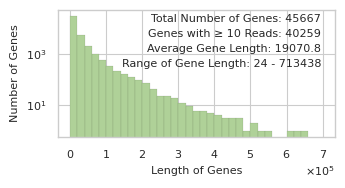

In [10]:
# PLOT: Length Distribution of Genes 
sns.set_theme(style = 'whitegrid', palette='colorblind', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8, "axes.formatter.use_mathtext": True})
plt.figure(figsize=(((9)/2.54), (5/2.54)))


# on the x axis: Length of genes
plt.xlabel('Length of Genes')
# on the y axis: Number of genes
plt.ylabel('Number of Genes')

# plot the histogram
plt.hist(data['gene_length'], bins=range(minima,maxima, 20000), color='#AFD198', edgecolor='black', linewidth=0.05)
plt.yscale('log')
xfmt = plt.ScalarFormatter()
xfmt.set_powerlimits((0,0)) 
plt.gca().xaxis.set_major_formatter(xfmt)

# LABELS: 
# add label for total number of genes 
plt.text(0.95, 0.97, f'Total Number of Genes: {len(total["gene_name"])}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=8)
# add total number of unique genes 
plt.text(0.95, 0.85, f"Genes with ≥ 10 Reads: {len(data['gene_name'].unique())}", ha='right', va='top', transform=plt.gca().transAxes, fontsize=8)
# add numer label for average at the top right corner 
plt.text(0.95, 0.73, f'Average Gene Length: {mean_genelength:.1f}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.text(0.95, 0.61, f'Range of Gene Length: {minima} - {maxima}', ha='right', va='top', transform=plt.gca().transAxes, fontsize=8)
plt.tight_layout()

# save the plot as png with 500 dpi
plt.savefig('12_gene_length_distribution/gene_length_distribution.svg')


# 6 Histogram for only the DMR genes and thei length

In [11]:
# read in DMR data (unique gene ids) 
with open('/home/maggy/WholeGenomeBisulphiteSequencing/DNAseq_pipeline/7_match_dmr_to_gene/dmr_within_geneborders_genelist/dmr_unique_geneids.json', 'r') as f:
    dmr_unique_geneids = json.load(f)
# concaternte all DMRs into one list 
dmr = [item for sublist in dmr_unique_geneids.values() for item in sublist]

In [12]:
# filter data to only keep the genes that are in the DMR list
data_dmr = data[data['gene_id'].isin(dmr)]

In [13]:
# calculate max length of gene length
dmr_maxima = data_dmr['gene_length'].max()
dmr_minima = data_dmr['gene_length'].min()
# calculate the average
dmr_median_genelength = data_dmr['gene_length'].median()

/tmp/ipykernel_9470/151610721.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_dmr['gene_length_kb'] = np.array(data_dmr['gene_length']) / 1000


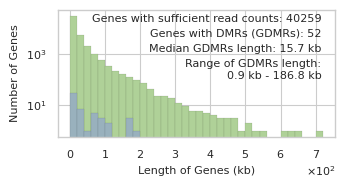

In [15]:
# PLOT: Length Distribution of Genes 
sns.set_theme(style = 'whitegrid', palette='colorblind', context='paper', rc={'axes.labelsize':8, 'xtick.labelsize':8, 'ytick.labelsize':8, 'legend.fontsize':8, 'legend.title_fontsize':8, "axes.formatter.use_mathtext": True})
plt.figure(figsize=(((9)/2.54), (5/2.54)))


# Convert lengths to kilobases
data['gene_length_kb'] = np.array(data['gene_length']) / 1000
data_dmr['gene_length_kb'] = np.array(data_dmr['gene_length']) / 1000

# on the x axis: Length of genes (in kb)
plt.xlabel('Length of Genes (kb)')
# on the y axis: Number of genes
plt.ylabel('Number of Genes')

# plot the histogram
plt.hist(data['gene_length_kb'], bins=range(0, int(max(data['gene_length_kb']) + 20), 20), 
         color='#AFD198', edgecolor='black', linewidth=0.05)
plt.hist(data_dmr['gene_length_kb'], bins=range(0, int(max(data_dmr['gene_length_kb']) + 20), 20), 
         color='#99B1BD', edgecolor='black', linewidth=0.05)
plt.yscale('log')
xfmt = plt.ScalarFormatter()
xfmt.set_powerlimits((0, 0))
plt.gca().xaxis.set_major_formatter(xfmt)

# LABELS: 
# add label for total number of genes 
plt.text(0.95, 0.97, f'Genes with sufficient read counts: 40259', ha='right', va='top', 
         transform=plt.gca().transAxes, fontsize=8)
# add total number of unique genes 
plt.text(0.95, 0.85, f"Genes with DMRs (GDMRs): {len(np.unique(data_dmr['gene_length']))}", ha='right', va='top', 
         transform=plt.gca().transAxes, fontsize=8)
# add numeric label for average at the top right corner 
plt.text(0.95, 0.73, f'Median GDMRs length: {dmr_median_genelength / 1000:.1f} kb', ha='right', va='top', 
         transform=plt.gca().transAxes, fontsize=8)
plt.text(0.95, 0.61, f'Range of GDMRs length:\n{dmr_minima / 1000:.1f} kb - {dmr_maxima / 1000:.1f} kb', ha='right', va='top', 
         transform=plt.gca().transAxes, fontsize=8)

plt.tight_layout()

# save the plot as svg with 500 dpi
plt.savefig('12_gene_length_distribution/dmr_length_distribution.svg')
